In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import collections
import functools
from matplotlib import colors
from IPython import display
import itertools
import copy
from time import sleep
from scipy.stats import levy
from scipy.stats import uniform

In [49]:
# helper functions
def get_left(position,r, size):
    i,j = position
    return [(i-r)%size, j]

def get_right(position,r,size):
    i,j = position
    return [(i+r)%size, j]

def get_top(position, r,size):
    i,j = position
    return [i, (j+r)%size]

def get_bottom(position, r,size):
    i,j = position
    return [i, (j-r)%size]

def get_top_right(position, r,size):
    i,j = position
    return [(i+r)%size, (j+r)%size]

def get_top_left(position, r,size):
    i,j = position
    return [i-r, j+r]

def get_bottom_right(position,r,size):
    i,j = position
    return [(i+r)%size,(j-r)%size]

def get_bottom_left(position,r,size):
    i,j = position
    return [(i-r)%size,(j-r)%size]


def levy_flight(steps):
    """
    Generates randomized levy flight step

    Parameters
    ----------
    Returns
    -------
    array
        x_pos = x position
        y_pos = y position
    """
    # Specify parameters
    # Uniformly distributed angles
    angles = uniform.rvs(size=(steps), loc=0, scale=2.*np.pi)

    # Levy distributed step length
    levy_random = levy.rvs(size=steps)

    # X and Y coordinates
    x_pos = np.cumsum(levy_random * np.cos(angles))
    x_pos = [int(i) for i in x_pos]
    y_pos = np.cumsum(levy_random * np.sin(angles))
    y_pos = [int(j) for j in y_pos]
    result = np.array([[i,j] for i,j in zip(x_pos,y_pos)])
    return result


(100, 2)


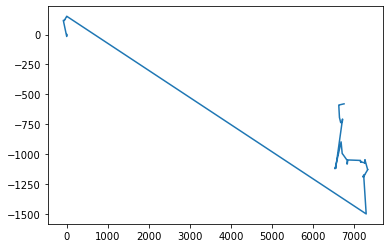

In [51]:
# test Levy
num_steps = 100
vals = levy_flight(num_steps)
print(vals.shape)
plt.plot(vals[:,0],vals[:,1])


In [56]:
class DLA:
    def __init__(self, grid_size, num_particles, num_steps):
        self.grid = np.zeros((grid_size,grid_size),dtype = int)
        self.grid_size = grid_size
        self.num_particles = num_particles
        self.particle_positions = []
        self.seed_positions = []
        self.num_steps = num_steps
        self.levy_steps = np.zeros((self.num_steps,2))
        self.initialize_grid()
        
    def initialize_grid(self):
        all_positions = self.get_grid_positions()
        self.particle_positions = random.sample(all_positions, self.num_particles)
        for position in self.particle_positions:
            self.grid[position[0]][position[1]] = 1 # Particle
        self.grid[self.grid_size//2][self.grid_size//2] = 2 # Seed
        self.seed_positions.append([self.grid_size//2,self.grid_size//2])
        self.levy_steps = levy_flight(self.num_steps)
           
    def get_grid_positions(self):
        l1 = [i for i in range(self.grid_size)]
        l2 = [i for i in range(self.grid_size)]
        return list(itertools.product(l1, l2))
    
    # periodic boundary condition
    def get_moore_neighbors(self, grid_position):
        r = 1
        neighbors = {"top": get_top(grid_position, r, self.grid_size),
                     "bottom":get_bottom(grid_position, r, self.grid_size),
                     "right":get_right(grid_position, r, self.grid_size),
                     "left":get_left(grid_position, r, self.grid_size),
                     "top_right":get_top_right(grid_position, r, self.grid_size),
                     "top_left":get_top_left(grid_position, r, self.grid_size),
                     "bottom_right":get_bottom_right(grid_position, r, self.grid_size),
                     "bottom_left":get_bottom_left(grid_position, r, self.grid_size)
                    }
        return neighbors
    
    def get_von_neumann_neighbors(self, grid_position):
        r = 1
        neighbors = {"top": get_top(grid_position, r, self.grid_size),
                     "bottom":get_bottom(grid_position, r, self.grid_size),
                     "right":get_right(grid_position, r, self.grid_size),
                     "left":get_left(grid_position, r, self.grid_size)
                    }
        return neighbors
    
    def update(self, neighborhood, update_particles, step):
        """
        Grow particles with choice of neighborhood = "M", "VN",
        options of speedup with Levy Flight
        Convert particles to seed if in neighborhood of seed particle
        Update grid
        """
        new_particle_positions = []
        for position in self.particle_positions:
            if update_particles == "Normal":
                if neighborhood == "VN":
                    neighbors = self.get_von_neumann_neighbors(position)
                else: #Moore
                    neighbors = self.get_moore_neighbors(position)
                new_particle_positions.append(random.choice(list(neighbors.values())))
            else: # Levy steps
                dstep = self.levy_steps[step]
                new_step = [(position[0]+dstep[0])%self.grid_size,
                            (position[1]+dstep[1])%self.grid_size]
                new_particle_positions.append(new_step)
        self.particle_positions.clear()
        self.particle_positions = new_particle_positions
        self.grid[:][:] = 0
        # update new_particles
        for particle in self.particle_positions:
            self.grid[particle[0]][particle[1]] = 1
        for seed in self.seed_positions:
            self.grid[seed[0]][seed[1]] = 2
            if neighborhood == "VN":
                neighbors = self.get_von_neumann_neighbors(seed)
            else: #Moore
                neighbors = self.get_moore_neighbors(seed) 
            # update neighbors
            for neighbor in neighbors.values():
                if self.grid[neighbor[0]][neighbor[1]] == 1:
                    self.particle_positions.remove(neighbor)
                    self.seed_positions.append(neighbor)
                    self.grid[neighbor[0]][neighbor[1]] = 2
                    

KeyboardInterrupt: 

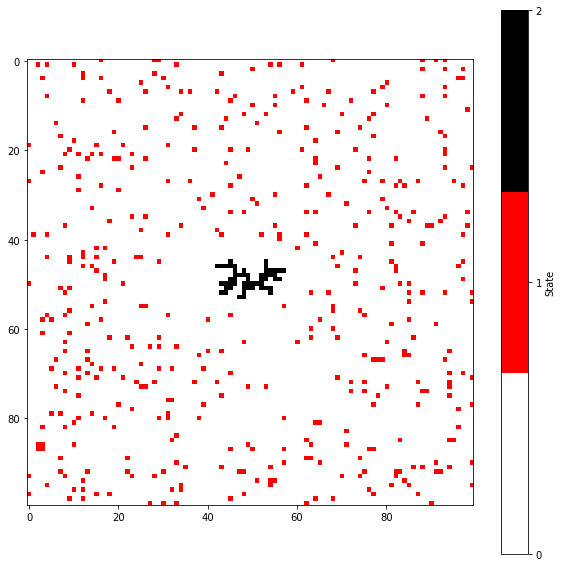

In [63]:
grid_size = 100
num_particles = 500
# run for num_steps
num_steps = 10000
dla = DLA(grid_size, num_particles, num_steps)
cmap = colors.ListedColormap(["white", "red", 'black'])
plt.figure(figsize=(10,10))
plt.imshow(dla.grid, cmap=cmap, vmin = 0, vmax = 2)
plt.colorbar(ticks=[0,1,2], label='State')
update_type = ["Normal", "Levy"]
for step in range(1,num_steps):
    dla.update("VN",update_type[0],step)
    plt.cla()
    plt.imshow(dla.grid, cmap=cmap, vmin = 0, vmax = 2)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.025)